In [1]:
# import h5py
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.utils import shuffle
from tqdm import tqdm
import torch
# import torch_geometric as geom
# import torch_geometric.data as geom_data
# from torch_geometric.data import Dataset as GeomDataset
from torch_geometric.nn import knn_graph
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
import os
import pandas as pd
# from torchvision import datasets, transforms

In [2]:
data_dir = Path('../data/downloaded/quark_gluon/')

train_files = []
test_files = []

for file in os.listdir(data_dir):
    if 'train' in file:
        train_files.append(data_dir/ file)
    else:
        test_files.append(data_dir/ file)

In [16]:
num_nodes = []
num_edges = []

In [4]:
def generate(pf, path, iter_batch_size, max_batches, file_idx, prefix):
    record_batch = pf.iter_batches(batch_size=iter_batch_size)
    count = 0
    
    while True:
        try:
            batch = next(record_batch)
            file_idx = transform_to_graph(batch, path, file_idx, prefix)
            count += 1
        except StopIteration as e:
            print(e)
            return file_idx

        if count == max_batches:
            break

    return file_idx

In [5]:
def transform_to_graph(batch, path, file_idx, prefix):
    p = batch.to_pandas()
    im = np.array(np.array(np.array(p.iloc[:, 0].tolist()).tolist()).tolist())
    meta = np.array(p.iloc[:, 3])
    return saver(im, meta, path, file_idx, prefix)

In [6]:
def saver(im, meta, path, file_idx, prefix):

    im[im < 1.e-3] = 0 #Zero_suppression
    im[:,0,:,:] = (im[:,0,:,:] - im[:,0,:,:].mean())/(im[:,0,:,:].std())
    im[:,1,:,:] = (im[:,1,:,:] - im[:,1,:,:].mean())/(im[:,1,:,:].std())
    im[:,2,:,:] = (im[:,2,:,:] - im[:,2,:,:].mean())/(im[:,2,:,:].std())

    new_file = True
    with tqdm(range(meta.shape[0]), unit='datum') as tbatch:   
        for i in tbatch:
            img = im[i,:,:,:]
            label = int(meta[i])

            channel1 = img[0,:,:]
            channel2 = img[1,:,:]
            channel3 = img[2,:,:]

            channel1 = np.clip(channel1, 0, 500*channel1.std())
            channel2 = np.clip(channel2, 0, 500*channel2.std())
            channel3 = np.clip(channel3, 0, 500*channel3.std())

            p = channel1.max() == 0.0
            q = channel2.max() == 0.0
            r = channel3.max() == 0.0

            if p | q | r:
                continue

            channel1 = channel1/channel1.max()
            channel2 = channel2/channel2.max()
            channel3 = channel3/channel3.max()

            img[0,:,:] = channel1
            img[1,:,:] = channel2
            img[2,:,:] = channel3

            img = img.T

            # graph conversion
            img = torch.Tensor(img)
            xhit, yhit, zhit = torch.nonzero(img, as_tuple=True)
            
#             print(xhit.shape, yhit.shape, zhit.shape)
            
            chs = [(zhit == 0).nonzero(as_tuple=True)[0], 
                  (zhit == 1).nonzero(as_tuple=True)[0], 
                  (zhit == 2).nonzero(as_tuple=True)[0]]
            
            
#             fig = plt.figure(figsize=(15,15))
#             for i in [2]:
#                 sc = plt.scatter(xhit[chs[i]], yhit[chs[i]], c = img[xhit[chs[i]], yhit[chs[i]], i])
#                 check=np.arange(0,125,4)
#                 plt.xticks(check)
#                 plt.yticks(check)
#                 plt.grid()
#                 plt.colorbar(sc)
#                 plt.show()

            hcal_indices = torch.stack((xhit[chs[2]], yhit[chs[2]])).T
            hcal_values =  img[xhit[chs[2]], yhit[chs[2]], 2]
            
            assert hcal_indices.shape[0]%5 == 0
            
#             print(hcal_indices.shape)
            # Reshape the padded array into groups of 5 elements
            grouped_indices = hcal_indices.reshape(-1, 5, 2).to(torch.float32)
            grouped_values = hcal_values.reshape(-1, 5)
#             print(grouped_indices)
#             print(grouped_values)
            
            # Calculate the mean along the second axis (axis=1)
            mean_indices = torch.mean(grouped_indices, axis=1).numpy()
#             print(mean_indices)
            mean_values = torch.mean(grouped_values, axis=1)
#             print(mean_values)
            
            mean_indices = mean_indices[np.lexsort((mean_indices[:, 0], mean_indices[:, 1]))]
            
#             print(mean_indices)
            
            mean_indices = torch.tensor(mean_indices)
        
            grouped_indices = mean_indices.reshape(-1, 5, 2).to(torch.float32)
            grouped_values = mean_values.reshape(-1, 5)
#             print(grouped_indices)
#             print(grouped_values)
            
            mean_indices = torch.mean(grouped_indices, axis=1).to(torch.int)
            mean_values = torch.mean(grouped_values, axis=1)
#             print(mean_indices)
#             print(mean_values)
            
            xhit = torch.cat((xhit[chs[0]], xhit[chs[1]], mean_indices[:,0])).to(torch.int)
            yhit = torch.cat((yhit[chs[0]], yhit[chs[1]], mean_indices[:,1])).to(torch.int)
            zhit = torch.cat((zhit[chs[0]], zhit[chs[1]], torch.ones(mean_indices.shape[0])*2)).to(torch.int)
            
#             z_indices = (zhit == 2).nonzero(as_tuple=True)[0]
#             fig = plt.figure(figsize=(15,15))
#             for i in [2]:
#                 sc = plt.scatter(xhit[z_indices], yhit[z_indices], c = img[xhit[z_indices], yhit[z_indices], i])
#                 check=np.arange(0,125,4)
#                 plt.xticks(check)
#                 plt.yticks(check)
#                 plt.grid()
#                 plt.colorbar(sc)
#                 plt.show()
            
            non_zero_values = img[xhit, yhit, zhit]
            node_feats = torch.stack((xhit, yhit, zhit, non_zero_values), dim=1)
            coords = node_feats[:, [0, 1, 2]]
            
            
#             for i, j in zip(xhit[chs[2]], yhit[chs[2]]):
#                 print(i,j, img[i,j, 2])
            
            if len(coords) == 0:
                continue

            # Create knn graph adjacency matrix
            edge_index = knn_graph(coords,
                                   k=16,
                                   batch=None,
                                   loop=True,
                                   num_workers=12)
            
            num_nodes.append(non_zero_values.shape[0])
            num_edges.append(edge_index.shape[1])

#             parquet_df = pd.DataFrame({
#                 'coords_x': [node_feats[:, 0].numpy()],
#                 'coords_y': [node_feats[:, 1].numpy()],
#                 'coords_z': [node_feats[:, 2].numpy()],
#                 'energy': [node_feats[:, 3].numpy()],
#                 'edge_index_from': [edge_index[0, :].numpy()],
#                 'edge_index_to': [edge_index[1, :].numpy()],
#                 'y': [label],
#             })

#             table = pa.Table.from_pandas(parquet_df)
#             if new_file:
#                 output_filename = Path(path) / f'{prefix}_{file_idx}.parquet'
#                 pqwriter = pq.ParquetWriter(output_filename, table.schema, compression='snappy')
#                 new_file = False
#                 file_idx += 1
#             pqwriter.write_table(table)
            
    return file_idx

In [7]:
processed_dir = Path('../data/processed/')

In [12]:
idx = 0
prefix = 'qg_train'
iter_batch_size = 3*1024
max_batches = -1

for raw_path in train_files[1:]:
    print("Processing file:", raw_path)
    idx = generate(pq.ParquetFile(raw_path), processed_dir, iter_batch_size, max_batches, idx, prefix)

print("The files were successfully generated") 

Processing file: ../data/downloaded/quark_gluon/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n297980.train.snappy.parquet


100%|███████████████████████████████████| 3068/3068 [00:03<00:00, 867.08datum/s]



Processing file: ../data/downloaded/quark_gluon/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n215556.train.snappy.parquet


100%|█████████████████████████████████████| 516/516 [00:00<00:00, 892.52datum/s]



The files were successfully generated


In [13]:
len(num_nodes), len(num_edges)

(793713, 793713)

In [14]:
print(f"{np.mean(num_nodes):.2f}")
print(f"{np.std(num_nodes):.2f}")
print(f"{np.min(num_nodes):.2f}")
print(f"{np.quantile(num_nodes, .25):.2f}")
print(f"{np.median(num_nodes):.2f}")
print(f"{np.quantile(num_nodes, .75):.2f}")
print(f"{np.max(num_nodes):.2f}")

332.81
130.09
24.00
239.00
313.00
405.00
1632.00


In [15]:
print(f"{np.mean(num_edges):.2f}")
print(f"{np.std(num_edges):.2f}")
print(f"{np.min(num_edges):.2f}")
print(f"{np.quantile(num_edges, .25):.2f}")
print(f"{np.median(num_edges):.2f}")
print(f"{np.quantile(num_edges, .75):.2f}")
print(f"{np.max(num_edges):.2f}")

5325.03
2081.38
384.00
3824.00
5008.00
6480.00
26112.00


In [ ]:
import numpy as np

def calculate_mean_in_groups(array):
    # Reshape the array to ensure its length is divisible by 5
    padded_array = np.pad(array, (0, 5 - (len(array) % 5)), mode='constant', constant_values=0)
    
    # Reshape the padded array into groups of 5 elements
    grouped_array = padded_array.reshape(-1, 5)
    
    # Calculate the mean along the second axis (axis=1)
    means = np.mean(grouped_array, axis=1)
    
    return means

# Example usage
array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
result = calculate_mean_in_groups(array)
print(result)


In [17]:
idx = 0
prefix = 'qg_test'
iter_batch_size = 3*1024
max_batches = -1

for raw_path in test_files:
    print("Processing file:", raw_path)
    idx = generate(pq.ParquetFile(raw_path), processed_dir, iter_batch_size, max_batches, idx, prefix)

print("The files were successfully generated") 

Processing file: ../data/downloaded/quark_gluon/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet


100%|█████████████████████████████████████| 198/198 [00:00<00:00, 817.84datum/s]



Processing file: ../data/downloaded/quark_gluon/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet


100%|███████████████████████████████████| 1460/1460 [00:01<00:00, 835.35datum/s]



Processing file: ../data/downloaded/quark_gluon/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet


100%|███████████████████████████████████| 2480/2480 [00:02<00:00, 863.37datum/s]


The files were successfully generated


In [18]:
len(num_nodes), len(num_edges)

(139274, 139274)

In [19]:
print(f"{np.mean(num_nodes):.2f}")
print(f"{np.std(num_nodes):.2f}")
print(f"{np.min(num_nodes):.2f}")
print(f"{np.quantile(num_nodes, .25):.2f}")
print(f"{np.median(num_nodes):.2f}")
print(f"{np.quantile(num_nodes, .75):.2f}")
print(f"{np.max(num_nodes):.2f}")

334.53
130.63
38.00
240.00
314.00
408.00
1404.00


In [20]:
print(f"{np.mean(num_edges):.2f}")
print(f"{np.std(num_edges):.2f}")
print(f"{np.min(num_edges):.2f}")
print(f"{np.quantile(num_edges, .25):.2f}")
print(f"{np.median(num_edges):.2f}")
print(f"{np.quantile(num_edges, .75):.2f}")
print(f"{np.max(num_edges):.2f}")

5352.40
2090.04
608.00
3840.00
5024.00
6528.00
22464.00


In [6]:
from torch_geometric.data import Dataset as GeomDataset
import torch_geometric.data as geom_data

class TrainParquetGeomDataset(GeomDataset):
    def __init__(self, root):
        self.filename = root
        self.parquet = pq.ParquetFile(self.filename)
#         self.has_process  = False
        super().__init__(root)
        
    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
        return [self.filename]

    def download(self):
        pass
    
#     def process(self):
#         print("HI")
    
    def len(self):
        return self.parquet.num_row_groups
    
    def get(self, idx):
        index = idx
        
        data = self.parquet.read_row_group(index,
                                           columns=None).to_pydict()

        node_feats = torch.cat(
            (torch.tensor(data['coords_x']), torch.tensor(data['coords_y']),
             torch.tensor(data['coords_z']), torch.tensor(data['energy'])),
            dim=0).T

        edge_index = torch.cat((torch.tensor(
            data['edge_index_from']), torch.tensor(data['edge_index_to'])),
                               dim=0)

        label = torch.tensor(data['y'], dtype=torch.int64)
        datum = geom_data.Data(x=node_feats, edge_index=edge_index, y=label)
        return datum

    def __len__(self):
        return self.parquet.num_row_groups

In [7]:
from torch.utils.data import ConcatDataset
# from torch.utils.data import Dataset, sampler, DataLoader
# from torchvision import transforms
# from torch_geometric.loader.dataloader import Collater


# class TrainParquetDataset(Dataset):

#     def __init__(self, filename):
#         self.parquet = pq.ParquetFile(filename)
#         self.cols = None

#     def __getitem__(self, index):
#         print(self.cols)
#         data = self.parquet.read_row_group(index,
#                                            columns=self.cols).to_pydict()

#         node_feats = torch.cat(
#             (torch.tensor(data['coords_x']), torch.tensor(data['coords_y']),
#              torch.tensor(data['coords_z']), torch.tensor(data['energy'])),
#             dim=0)

#         edge_index = torch.cat((torch.tensor(
#             data['edge_index_from']), torch.tensor(data['edge_index_to'])),
#                                dim=0)

#         label = torch.tensor(data['y'], dtype=torch.int64)

#         datum = geom_data.Data(x=node_feats, edge_index=edge_index, y=label)
#         return datum

#     def __len__(self):
#         return self.parquet.num_row_groups

In [8]:
train_files = [processed_dir / f'qg_train_{i}.parquet' for i in range(1)]

In [9]:
train_files

[PosixPath('../data/processed/qg_train_0.parquet')]

In [10]:
import torch_geometric.transforms as T

def power2_node_pad(data):
    n_node = torch.tensor(data.x.shape[0])
    pad = int(2 ** torch.ceil(torch.log2(n_node)))
    return T.Pad(pad, mask_pad_value=True)(data)

In [11]:
dset_train = ConcatDataset([
    TrainParquetGeomDataset(d)
    for d in train_files
])

In [15]:
import torch_geometric as geom
graph = geom.utils.to_networkx(dset_train[0])

In [41]:
batch_size = 2
# idxs = np.random.permutation(len(dset_train))
# random_sampler = sampler.SubsetRandomSampler(idxs)
data_loader = geom_data.DataLoader(dataset=dset_train,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=1,
#                          sampler=random_sampler,
                         pin_memory=True)

In [30]:
dict(zip(list(graph.nodes), np.array(dset_train[0].x[:,0:3])))

{0: array([0., 5., 2.], dtype=float32),
 1: array([0., 6., 2.], dtype=float32),
 2: array([0., 7., 2.], dtype=float32),
 3: array([0., 8., 2.], dtype=float32),
 4: array([0., 9., 2.], dtype=float32),
 5: array([ 0., 13.,  0.], dtype=float32),
 6: array([ 0., 18.,  0.], dtype=float32),
 7: array([ 0., 23.,  1.], dtype=float32),
 8: array([1., 5., 2.], dtype=float32),
 9: array([1., 6., 2.], dtype=float32),
 10: array([1., 7., 2.], dtype=float32),
 11: array([1., 8., 2.], dtype=float32),
 12: array([1., 9., 2.], dtype=float32),
 13: array([  1., 107.,   1.], dtype=float32),
 14: array([2., 5., 2.], dtype=float32),
 15: array([2., 6., 2.], dtype=float32),
 16: array([2., 7., 2.], dtype=float32),
 17: array([2., 8., 2.], dtype=float32),
 18: array([2., 9., 2.], dtype=float32),
 19: array([ 2., 29.,  0.], dtype=float32),
 20: array([ 2., 89.,  0.], dtype=float32),
 21: array([3., 5., 2.], dtype=float32),
 22: array([3., 6., 2.], dtype=float32),
 23: array([3., 7., 2.], dtype=float32),
 24: 

array([2., 2., 2., 2., 2., 0., 0., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2.,
       2., 2., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 2., 2., 2., 2.,
       2., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 1., 1., 0., 2., 2., 2., 2.,
       2., 1., 1., 0., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 1., 2., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 0., 1., 1., 1.

In [29]:
list(graph.nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'node_attr_dict_factory',
 'node_di

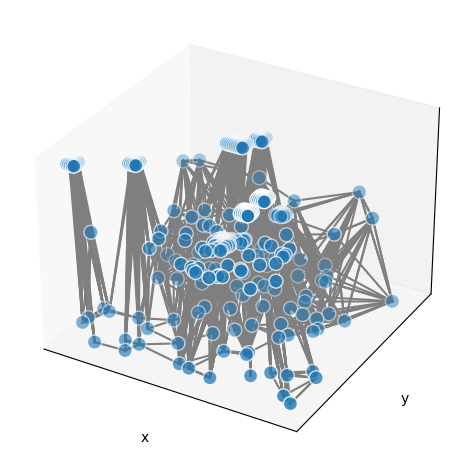

In [31]:
# %matplotlib widget
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
G = graph

# 3d spring layout
pos = dict(zip(list(graph.nodes), np.array(dset_train[0].x[:,0:3])))
# pos = nx.spring_layout(G, dim=3, seed=779)
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()